#  Classificação de evasão

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

## Tratamento dos dados e analise, usando pandas

In [87]:
data = pd.read_csv(r'dataset/UFC.csv',sep=',',encoding='latin')

In [88]:
data['modalidade_considerada'].value_counts()

modalidade_considerada
       191484
AC      21741
L2       7451
L6       7382
L1       3185
L5       2814
L14       346
L10       345
L13       199
L9        179
Name: count, dtype: int64

In [89]:
TipoDeModalidade = data['modalidade_considerada'].value_counts().index.to_list()[1:]
TipoDeModalidade

['AC', 'L2', 'L6', 'L1', 'L5', 'L14', 'L10', 'L13', 'L9']

### Há dados que não tem modalidade devido na época ser vestibular e não enem , só sera usado dados com modalidade 
* Desvantagem
    * perca de dados

In [90]:
data = data.loc[
    data['modalidade_considerada'].isin(TipoDeModalidade)
]

### Retirando dados que não serão usado

In [91]:
data.drop(
    columns=[
        'matricula',
        'codigo_inep',
        'nome_curso',
        'nome_unidade',
    ],inplace=True
)

In [92]:
data.head(4)

,sexo,forma_ingresso,ano_ingresso,periodo_ingresso,modalidade_considerada,status,ano_saida,periodo_saida
0,M,SELEÇÃO SISU,2020,1,L2,CANCELADO,2020,2
1,M,SELEÇÃO SISU,2017,1,L2,CANCELADO,2018,1
2,M,SELEÇÃO SISU,2017,1,L2,CANCELADO,2020,1
3,M,SELEÇÃO SISU,2017,1,L6,CANCELADO,2022,1


In [93]:
data['forma_ingresso'].value_counts()

forma_ingresso
SELEÇÃO SISU         43641
CONVÊNIO PAEC/OEA        1
Name: count, dtype: int64

### Forma de ingresso e tem poucos dados sera removido 

In [94]:
data.drop(
    columns='forma_ingresso',inplace=True
)

In [95]:
data['status'].value_counts()

status
ATIVO                         23456
CANCELADO                     16177
CONCLUÍDO                      3050
ATIVO - FORMANDO                432
EM MATRÍCULA INSTITUCIONAL      256
TRANCADO                        197
EM MOBILIDADE                    44
ATIVO - GRADUANDO                30
Name: count, dtype: int64

In [96]:
data['ano_saida'].value_counts()

ano_saida
        24415
2022     6299
2023     2812
2020     2810
2021     2619
2019     2246
2018     1690
2017      751
Name: count, dtype: int64

In [97]:
data.loc[data['ano_saida']==' ']

,sexo,ano_ingresso,periodo_ingresso,modalidade_considerada,status,ano_saida,periodo_saida
7,M,2017,1,AC,ATIVO,,
13,F,2022,1,L6,ATIVO,,
16,M,2019,1,AC,ATIVO,,
17,M,2020,1,L6,ATIVO,,
19,M,2019,1,AC,ATIVO,,
...,...,...,...,...,...,...,...
234810,M,2019,2,AC,ATIVO,,
234811,M,2017,2,AC,ATIVO,,
234812,M,2019,2,L6,ATIVO,,
234813,M,2019,2,AC,ATIVO,,


In [98]:
pd.set_option('mode.chained_assignment', None)

data['TempoNaUne'] = 0
for index,series in data.iterrows():

    if (series['ano_saida'] == ' '):
        data['TempoNaUne'][index] = 0
    else:
        data['TempoNaUne'][index] = abs(int(series['ano_saida']) - int(series['ano_ingresso']))

### Removendo ano_saida	periodo_saida pq tem dados nulos

In [101]:
data.drop(
    columns=['ano_saida','periodo_saida'],inplace=True
)

KeyError: "['ano_saida', 'periodo_saida'] not found in axis"

In [102]:
data.head(3)

,sexo,ano_ingresso,periodo_ingresso,modalidade_considerada,status,TempoNaUne
0,M,2020,1,L2,CANCELADO,0
1,M,2017,1,L2,CANCELADO,1
2,M,2017,1,L2,CANCELADO,3


In [100]:
data.groupby(by=['status'])['TempoNaUne'].count()

status
ATIVO                         23456
ATIVO - FORMANDO                432
ATIVO - GRADUANDO                30
CANCELADO                     16177
CONCLUÍDO                      3050
EM MATRÍCULA INSTITUCIONAL      256
EM MOBILIDADE                    44
TRANCADO                        197
Name: TempoNaUne, dtype: int64

### concluido saira
### E todo diferente de cancelado sera ainda na univesidade (NaUne)

In [103]:
data.drop(
    data.loc[data['status']=='CONCLUÍDO'].index,inplace=True
)

In [104]:
pd.set_option('mode.chained_assignment', None)

In [105]:
data['status'].loc[data['status'] =='ATIVO']                = 'NaUne'
data['status'].loc[data['status'] =='ATIVO - FORMANDO']     = 'NaUne'
data['status'].loc[data['status'] =='EM MATRÍCULA INSTITUCIONAL'] = 'NaUne'
data['status'].loc[data['status'] =='EM MOBILIDADE']     = 'NaUne'
data['status'].loc[data['status'] =='ATIVO - GRADUANDO'] = 'NaUne'
data['status'].loc[data['status'] =='TRANCADO'] = 'NaUne'


In [110]:
data.groupby(by=['status'])['TempoNaUne'].value_counts()

status     TempoNaUne
CANCELADO  1              4951
           0              4855
           2              3046
           3              1669
           4               876
           5               613
           6               167
NaUne      0             24415
Name: count, dtype: int64

In [68]:
from sklearn.preprocessing   import LabelBinarizer,LabelEncoder
from sklearn.metrics         import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.naive_bayes     import BernoulliNB

In [69]:
dummiesModalidade   = pd.get_dummies(
    data['modalidade_considerada'],prefix='modalidade_considerada',dtype=int
)

In [70]:
data.drop(
    columns = ['modalidade_considerada'],inplace=True
)

In [71]:
data = pd.concat(
    [
        data,
        dummiesModalidade
    ],axis=1
)

In [72]:
data['sexo'] = LabelBinarizer().fit_transform(data['sexo'])

In [74]:
classStatus = LabelEncoder()

In [75]:
data['status'] = classStatus.fit_transform(data['status'])

In [76]:
classStatus.classes_

array(['CANCELADO', 'NaUne'], dtype=object)

In [77]:
X = data.drop(columns='status')
Y = data['status']

In [78]:
x_train , x_test , y_train , y_test = train_test_split(X,Y,test_size=0.3)

## Regressão Logistica

In [79]:
LogisticRegress = LogisticRegression()

In [80]:
fitsLR = LogisticRegress.fit(x_train,y_train)

In [81]:
ypredRL = fitsLR.predict(x_test)

Text(0.5, 1.0, '0.880604368533421')

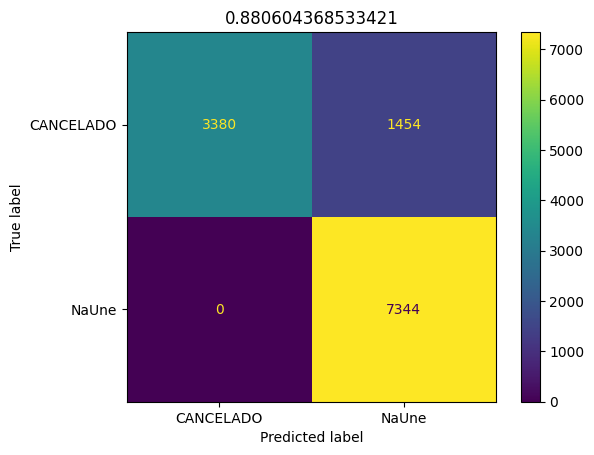

In [83]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test,ypredRL),
    display_labels=classStatus.classes_
).plot()
plt.title(f'{accuracy_score(y_test,ypredRL)}')

### Bernoulli

In [117]:
Bernoulli = BernoulliNB()

In [118]:
fitsLR = Bernoulli.fit(x_train,y_train)

In [119]:
ypredBN = fitsLR.predict(x_test)

Text(0.5, 1.0, '0.880604368533421')

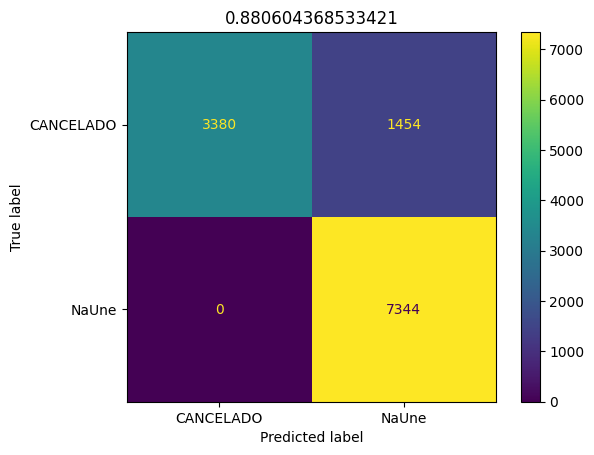

In [120]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test,ypredBN),
    display_labels=classStatus.classes_
).plot()
plt.title(f'{accuracy_score(y_test,ypredBN)}')

# Resultados

Devido ao tratamento de dados houve perca de dados isso afeta acuracia e classficação